# Store Sales - Time Series Forecasting

#### Here I will use ARIMA model in order to forecast store sales using certain dataset. Further I'm planning to enhance this project by introducing SARIMA and another machine learning model, comparing their performance, thereafter.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sales_df = pd.read_csv("train.csv")
sales_df.head()

,Date,store,product,number_sold
0,2010-01-01,0,0,801
1,2010-01-02,0,0,810
2,2010-01-03,0,0,818
3,2010-01-04,0,0,796
4,2010-01-05,0,0,808


In [3]:
sales_df.number_sold.count()

np.int64(230090)

In [4]:
sales_df.dtypes

Date           object
store           int64
product         int64
number_sold     int64
dtype: object

In [5]:
sales_df['Date'] = pd.to_datetime(sales_df.Date)
sales_df.dtypes

Date           datetime64[ns]
store                   int64
product                 int64
number_sold             int64
dtype: object

In [6]:
# sales_df.drop(columns=['TxnDate', 'TxnTime'], inplace=True)

In [7]:
sales_df.head(0)

,Date,store,product,number_sold


In [8]:
sales_df.describe()

,Date,store,product,number_sold
count,230090,230090.000000,230090.000000,230090.000000
mean,2014-07-01 23:59:59.999999744,3.000000,4.500000,780.926107
min,2010-01-01 00:00:00,0.000000,0.000000,238.000000
25%,2012-04-01 00:00:00,1.000000,2.000000,722.000000
50%,2014-07-02 00:00:00,3.000000,4.500000,835.000000
75%,2016-10-01 00:00:00,5.000000,7.000000,914.000000
max,2018-12-31 00:00:00,6.000000,9.000000,1205.000000
std,NaN,2.000004,2.872288,204.096737


In [9]:
sales_df.tail()

,Date,store,product,number_sold
230085,2018-12-27,6,9,890
230086,2018-12-28,6,9,892
230087,2018-12-29,6,9,895
230088,2018-12-30,6,9,899
230089,2018-12-31,6,9,912


Text(0, 0.5, 'Sales')

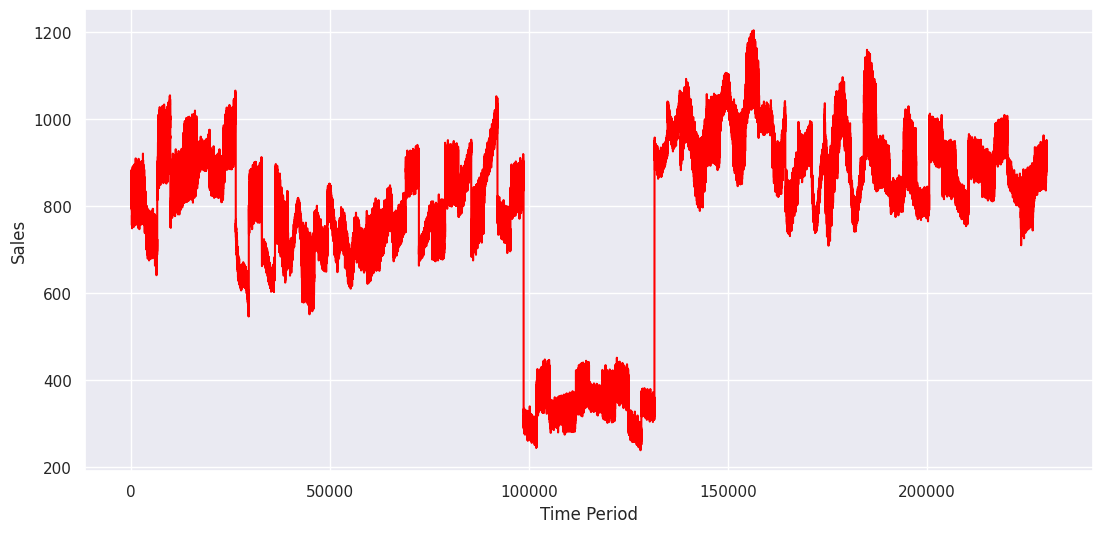

In [10]:
sns.set(font_scale=1)
sales_df["number_sold"].plot(figsize=(13, 6), color="red")
plt.xlabel("Time Period")
plt.ylabel("Sales")

In [11]:
test_sales_df = pd.read_csv("test.csv")
sales_df['Date'] = pd.to_datetime(sales_df.Date)

In [12]:
test_sales_df.head(1)

,Date,store,product,number_sold
0,2019-01-01,0,0,845


In [13]:
test_sales_df.tail(1)

,Date,store,product,number_sold
25549,2019-12-31,6,9,886


In [14]:
sales_df.dropna(inplace=True)
test_sales_df.dropna(inplace=True)

<Axes: >

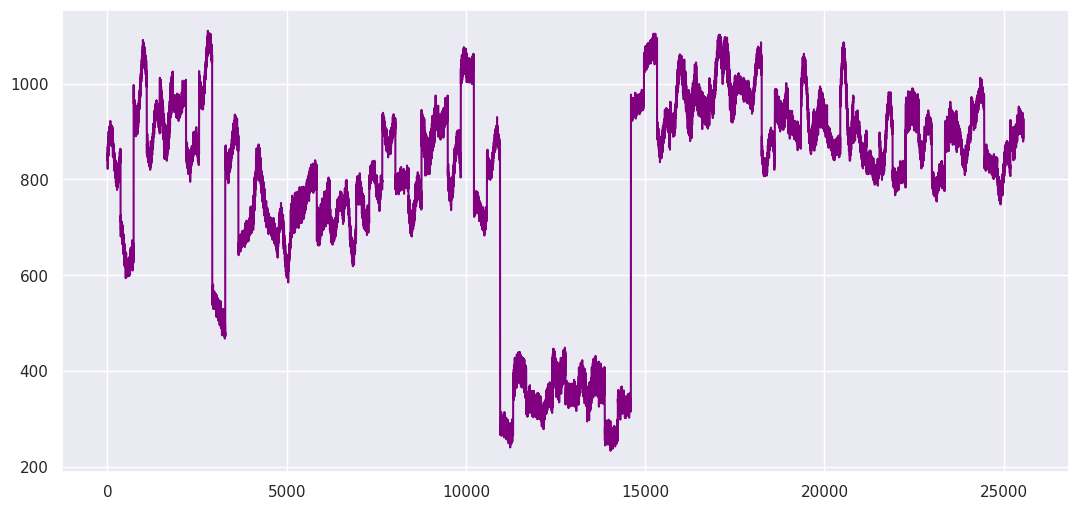

In [14]:
test_sales_df["number_sold"].plot(figsize=(13, 6), color="purple")

# Time Series Decomposition

<Figure size 2400x1560 with 0 Axes>

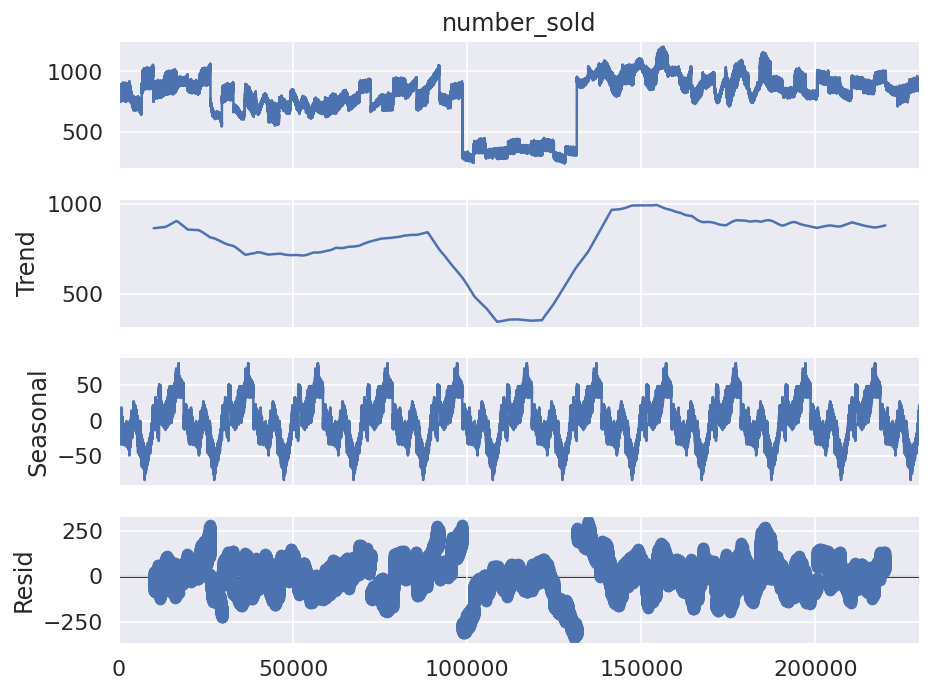

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
sales_df['date_delta'] = (sales_df['Date'] - sales_df['Date'].min()) / np.timedelta64(1,'D')
dres = seasonal_decompose(sales_df.number_sold,  period=20000)
sns.set(font_scale=1.2)
plt.figure(figsize=(20, 13))
dres.plot();

### Autocorrelation

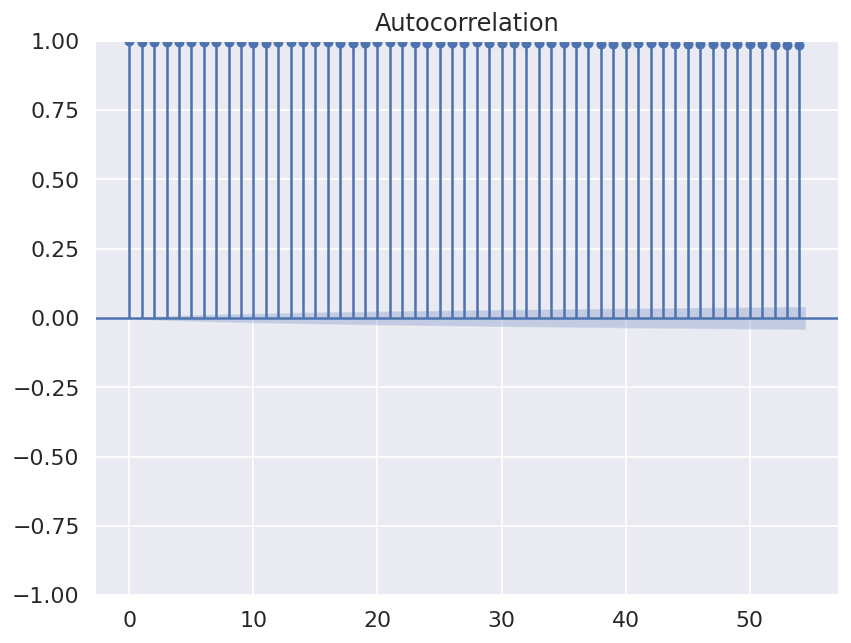

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
plot_acf(sales_df.number_sold);

#### To prevent seeing duplicate effects of the autocorrelation function (ACF) and to review train_df from another perspective, the partial autocorrelation function (PACF) will be used. In addition, partial autocorrelation will help us choose optimal range of the Moving Average Order (q-value).

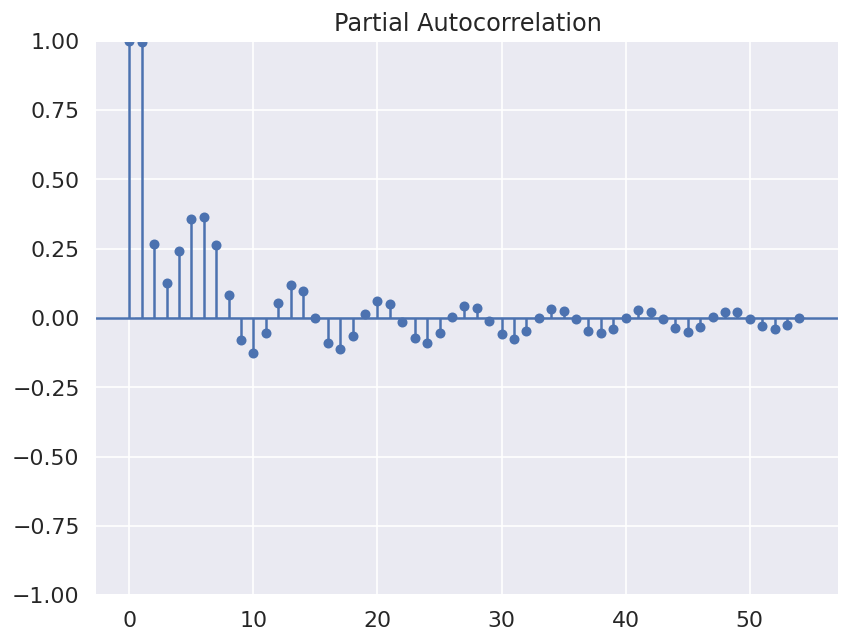

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
plot_pacf(sales_df.number_sold);

#### First seven lags appear highly significant, the values of q will be considered in the range between 2 and 7.

# Trend and Stationarity

In [18]:
from statsmodels.tsa.stattools import adfuller

part_of_sales_df = sales_df[sales_df.Date > "2016-01-01"]
adf, pval, usedlag, nobs, crit_vals, icbest = adfuller(part_of_sales_df.number_sold.values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -4.250468288111451
ADF p-values: 0.0005406173824978447
ADF number of lags used: 64
ADF number of observations: 76585
ADF critical values: {'1%': np.float64(-3.4304353890343386), '5%': np.float64(-2.8615777404882397), '10%': np.float64(-2.566790087963416)}
ADF best information criterion: 606826.1778192042


In [19]:
!pip install pymannkendall

### According to the results of the Augmented Dickey Fuller test, we reject the null hypothesis, since the p-value is around 0.000541 which is less than 0.05. In other words, the time series we have is stationary. For further research, I will set the differencing level (d) of the ARIMA and SARIMA models to 0, since there is no need to difference it.

## Why is it needed to check for a trend?

### The trend in a Time Series dataset allows us to decide on which model would be further used for forecasting, for instance, performing double exponential smoothing requires a trend. It also allows us to better understand the essence of the dataset.

#### If we recall the decomposition performed earlier, there is seasonality in the train dataset, however, the trend is not as simple to spot. Let's use Mann-Kendall algorithm to determine whether the trend exists.

In [ ]:
import pymannkendall as mk
part_of_sales_df = sales_df[sales_df.Date > "2017-01-01"]

mk.original_test(part_of_sales_df.number_sold, alpha=0.05)

#### The test has shown that there is an increasing trend.

# ARIMA Model

## Importing corresponding libraries

In [22]:
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

## Fitting the model

In [23]:
train = sales_df
test = test_sales_df
arima = ARIMA(train['number_sold'], order=(3, 0, 5))
train_res = arima.fit()

In [24]:
print(train_res.summary())

                               SARIMAX Results                                
Dep. Variable:            number_sold   No. Observations:               230090
Model:                 ARIMA(3, 0, 5)   Log Likelihood             -890101.013
Date:                Thu, 25 May 2023   AIC                        1780222.026
Time:                        17:38:40   BIC                        1780325.488
Sample:                             0   HQIC                       1780252.293
                             - 230090                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        780.9261   2.67e-08   2.93e+10      0.000     780.926     780.926
ar.L1          2.2452      0.000   1.67e+04      0.000       2.245       2.245
ar.L2         -2.2426      0.000  -9361.020      0.0

### For the MA (q) orders, each of them is statistically significant, according to corresponding p-values. For AR (p) order, again, each are stastically significant. Let's try using a few more two see the difference.

In [25]:
train = sales_df
test = test_sales_df
arima = ARIMA(train['number_sold'], order=(8, 0, 4))
train_res = arima.fit()

In [26]:
print(train_res.summary())
# params = train_res.params

                               SARIMAX Results                                
Dep. Variable:            number_sold   No. Observations:               230090
Model:                 ARIMA(8, 0, 4)   Log Likelihood             -895600.181
Date:                Thu, 25 May 2023   AIC                        1791228.362
Time:                        17:48:54   BIC                        1791373.209
Sample:                             0   HQIC                       1791270.735
                             - 230090                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        780.9261    187.388      4.167      0.000     413.652    1148.201
ar.L1         -0.3004      0.004    -81.847      0.000      -0.308      -0.293
ar.L2          0.7232      0.003    257.483      0.0

### The AIC and BIC values were increased to some extent, although each order is statistically significant, according to corresponding p-values.

In [27]:
predictions = train_res.predict()

## Visualizing results

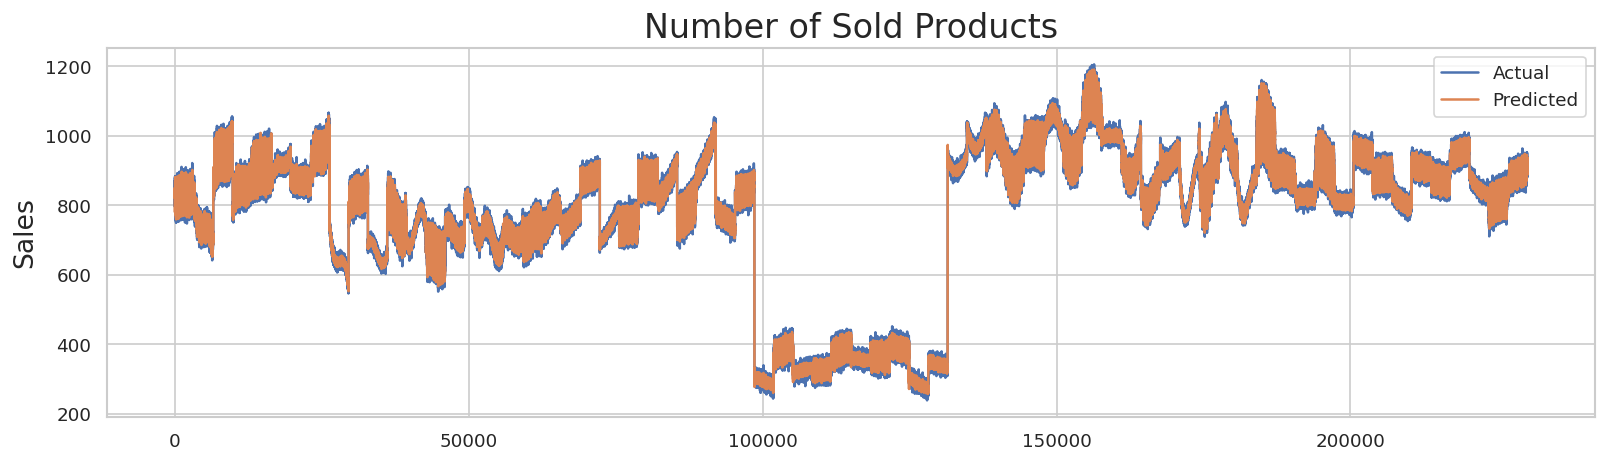

In [28]:
plt.figure(figsize=(16,4))
plt.plot(sales_df['number_sold'], label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Number of Sold Products', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

### The model seems to be well-fitted

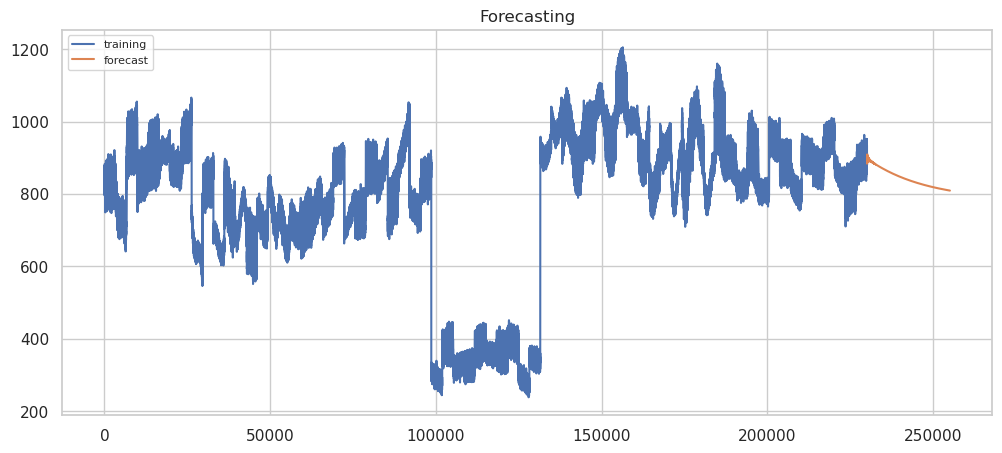

In [29]:
# Forecast
fc = train_res.forecast(25000, alpha=0.05)  # 95% conf

# pred = train_res.predict(start=230000, end =250000)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.number_sold, label='training')
plt.plot(fc, label='forecast')

plt.title('Forecasting')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### According to the results of forecasting, the decline of the number of products sold will most probably take place in the future. Now, another dataset will be uploaded to be analyzed using both ARIMA and SARIMA. Next, the direction of the research will be directed on Cross-Validation and Accuracy Measurement. The technology called auto-arima will be used for creating both ARIMA and SARIMA models.

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-11-24 16:40:17.778771: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-24 16:40:18.025508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732477218.167573   46043 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732477218.205961   46043 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 16:40:18.468323: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1


In [4]:
%pip install torch
import torch
print(torch.cuda.is_available())


  Using cached torch-2.5.1-cp312-cp312-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-